In [243]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import porespy as ps
import scipy as sp

import sys
sys.path.append("../src/")

import numpy as np
import pandas as pd

import torch

from torchvision.datasets import MNIST, CIFAR10
from torchvision.io import read_image

from torchvision.transforms.v2 import Compose
from torchvision.transforms.v2 import ToImage, Lambda, Resize, CenterCrop, ToDtype
from transforms import SoftThreshold, HardThreshold, Dilate

from sklearn.decomposition import PCA

import gudhi as gd
from tqdm import tqdm

np.set_printoptions(precision=1, suppress=True, linewidth=120, edgeitems=45, threshold=100)
torch.set_printoptions(precision=1, sci_mode=False, linewidth=120, edgeitems=45, threshold=100)

In [329]:
from typing import Any, Dict
from torchvision.transforms.v2 import Transform
from scipy.ndimage import rotate

def direction_filter(img, alpha, agg="mult"):
    if len(img.shape)==3:
        width, height = img.shape[1], img.shape[2]
    elif len(img.shape)==2:
        width, height = img.shape[0], img.shape[1]
    else:
        raise ValueError()
        
    if width==28:
        img_out = np.zeros((40, 40))
        img_out[6:34, 6:34] = img
        filter_hor = np.repeat(np.linspace(1, 0, 40), 40).reshape(40, 40).T
        filter_dir = (rotate(filter_hor, alpha, reshape=False))[6:34,:][:,6:34]
    elif width==32:
        img_out = np.zeros((46, 46))
        img_out[7:39, 7:39] = img
        filter_hor = np.repeat(np.linspace(1, 0, 46), 46).reshape(46, 46).T
        filter_dir = (rotate(filter_hor, alpha, reshape=False))[7:39,:][:,7:39]
    elif width==64:
        img_out = np.zeros((92, 92))
        img_out[14:78, 14:78] = img
        filter_hor = np.repeat(np.linspace(1, 0, 92), 92).reshape(92, 92).T
        filter_dir = (rotate(filter_hor, alpha, reshape=False))[14:78,:][:,14:78]
    else:
        raise ValueError("Only sizes of 28x28, 32x32, and 64x64 pixels are supported.")
        
    if agg=="mult":
        g = np.multiply
    elif agg=="add":
        g = np.add
    elif agg=="min":
        g = np.minimum
    elif agg=="max":
        g = np.maximum
    else:
        raise ValueError("Aggregation function is either 'mult', 'min' or 'max'.")
    
    return torch.Tensor(g(filter_dir, img))

class Direction(Transform):
    """Transform an image with the direction transform."""
    def __init__(self, alphas, agg="mult"):
        super().__init__()
        self.agg = agg
        self.alphas = alphas
        self.weight = alphas

    def transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        output = torch.zeros(len(self.alphas), inpt.shape[-2], inpt.shape[-1])
        for i, alpha in enumerate(self.alphas):
            output[i] = direction_filter(inpt, alpha, self.agg)
        return output

In [122]:
def pht(image, pos=None, eps=None):
    
    if len(image.shape)!=3:
        raise ValueError("Image tensor dimensions should be (channel, width, height).")
    
    dim = 4 if pos is not None else 3
    dgm_pht = torch.zeros((0, dim))
    dgms = sublevel_persistence(image, eps=eps, pos=pos, sort="persistence")

    for i, dgm in enumerate(dgms):
        dgm_pht = torch.cat([dgm_pht, dgm])

    return dgm_pht

def sublevel_persistence(image, eps=None, pos=None, inf="max", sort="birth"):
    
    if len(image.shape)!=3:
        raise ValueError("Image tensor dimensions should be (channel, width, height).")
    
    diagrams = []
    persistence = lambda x: x[:,1] - x[:,0]
    
    # for each channel
    for k, channel in enumerate(image):
        diagram_channel_gudhi = gd.CubicalComplex(top_dimensional_cells=channel).persistence()
        
        # convert a diagram from GUDHI format to n x 3 ndarray
        diagram_channel = np.zeros((len(diagram_channel_gudhi), 3))
        for i, (dim, (birth, death)) in enumerate(diagram_channel_gudhi):
            diagram_channel[i] = (birth, death, dim)
    
        # work with infs
        if inf=="max":
            diagram_channel = np.nan_to_num(diagram_channel, posinf=torch.max(channel))
        elif inf=="remove":
            diagram_channel = diagram_channel[~np.isinf(diagram_channel).any(axis=1)]
        else:
            raise ValueError("Inf should be 'max' or 'remove'.")
            
        # remove points w/ persistence less \eps
        if eps is not None:
            diagram_channel = diagram_channel[persistence(diagram_channel) > eps]
            
        # add positional encoding
        if pos is not None:
            pos_elements = np.repeat(pos[k], len(diagram_channel))[..., np.newaxis]
            diagram_channel = np.concatenate([diagram_channel, pos_elements], axis=1)
            
        # sort by dim, then birth or persistence
        if sort=="birth":
            sort_idx = np.lexsort([diagram_channel[:,0], diagram_channel[:,2]])
        elif sort=="persistence":
            sort_idx = np.lexsort([persistence(diagram_channel), diagram_channel[:,2]])
        else:
            raise ValueError("Sort should be 'birth' or 'persistence'.")
        diagram_channel = diagram_channel[sort_idx]
            
        diagrams.append(torch.tensor(diagram_channel))
        
    return diagrams

### MNIST

In [52]:
mnist_train = MNIST(root="../data/_tmp/", train=True, download=True)
mnist_test = MNIST(root="../data/_tmp/", train=False, download=True)

X_mnist_train, y_mnist_train = mnist_train.data, mnist_train.targets
X_mnist_test, y_mnist_test = mnist_test.data, mnist_test.targets

In [53]:
X_mnist_train.shape, X_mnist_test.shape, y_mnist_train.shape, y_mnist_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [54]:
X_mnist_train.dtype, X_mnist_test.dtype, y_mnist_train.dtype, y_mnist_test.dtype

(torch.uint8, torch.uint8, torch.int64, torch.int64)

In [55]:
rng = np.random.default_rng(0)
idx = rng.choice(range(len(X_mnist_train)), 10, replace=False)

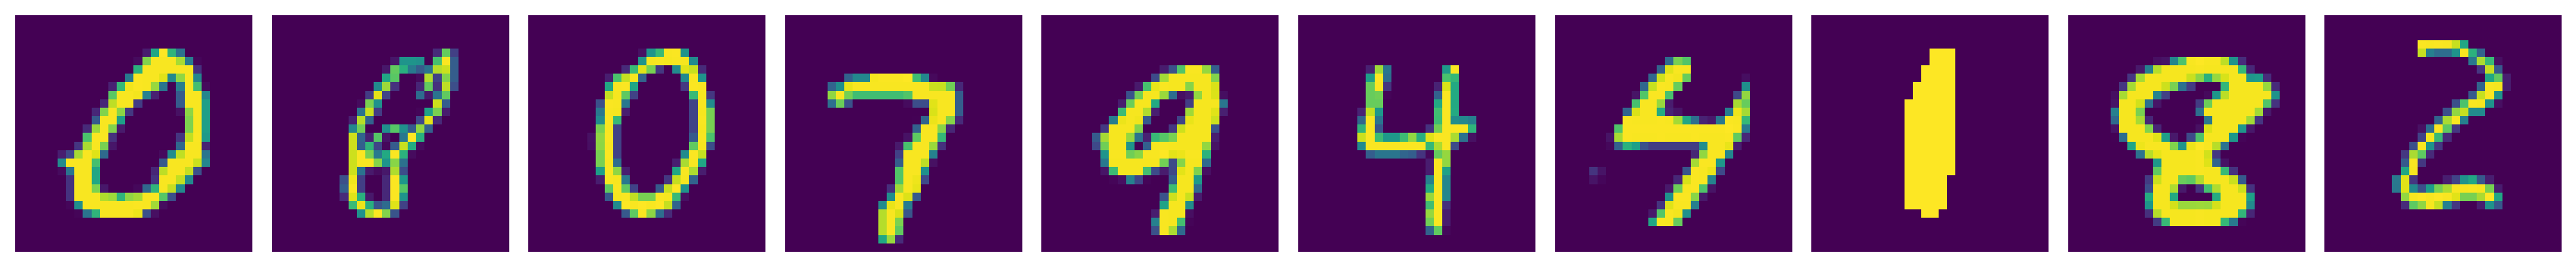

In [56]:
fig, ax = plt.subplots(ncols=10, figsize=(17, 1.7), dpi=200)
for i, ii in enumerate(idx):
    ax[i].axis("off")
    ax[i].imshow(X_mnist_train[ii].numpy())
plt.tight_layout(pad=0.5)
plt.show()

In [57]:
transform_mnist = Compose([
    Lambda(lambda x: x / 255),
    ToDtype(torch.float32, scale=True),
])

In [427]:
alphas = list(np.linspace(0, 360, 16+1)[:-1])
f = Direction(alphas, agg="add")

img = transform_blobs(X_blobs[1])
img_filtered = f(img) # f(transform_mnist(X_cifar_train[0,:,:,2]))
img_filtered.shape

torch.Size([16, 64, 64])

In [430]:
def imshow3d(img, ax):

    w, h = img.shape
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    x, y = grid_x.ravel(), grid_y.ravel()

    width = depth = 1
    top = img.T.flatten()
    bottom = np.zeros_like(top)

    cmap = cm.get_cmap('bwr')
    rgba = [cmap(p) for p in top]
    
    ax.view_init(elev=15, azim=30, roll=0)
    ax.bar3d(x, y, bottom, width, depth, top, color=rgba, shade=True)

/var/folders/29/7zhc2w2n7jn0l4p1tyzskm3w0000gn/T/ipykernel_20091/732349196.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('bwr')


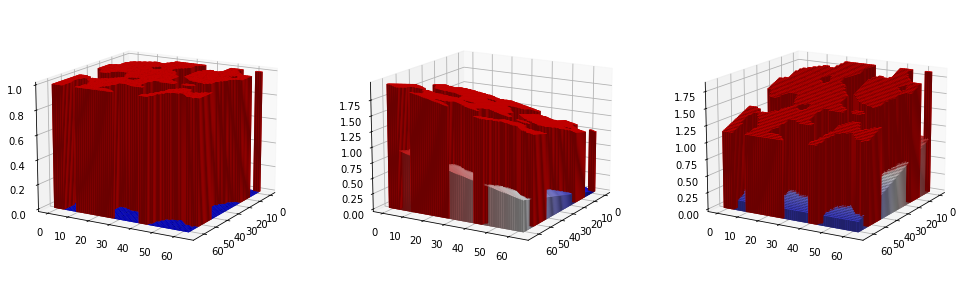

In [431]:
fig, ax = plt.subplots(ncols=3, subplot_kw=dict(projection="3d"), figsize=(17,5))
imshow3d(img, ax[0])
imshow3d(img_filtered[2], ax[1])
imshow3d(img_filtered[12], ax[2])
plt.show()

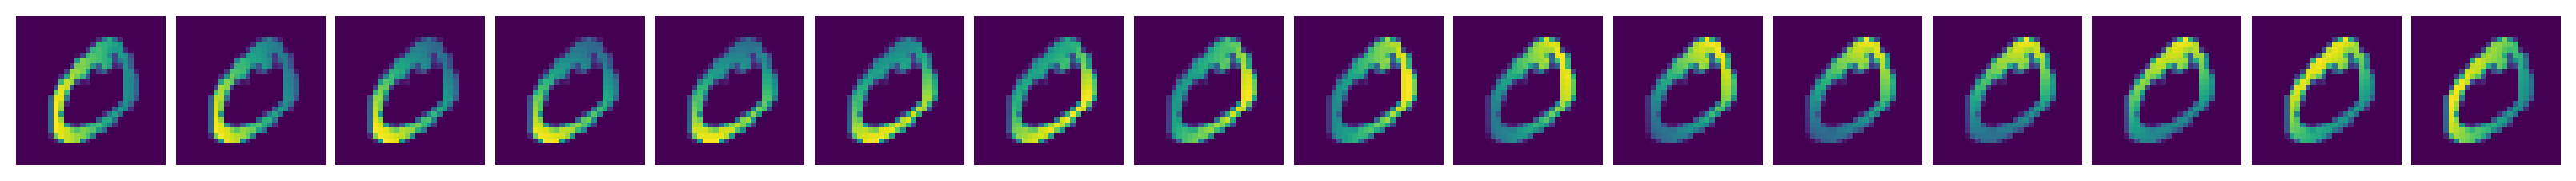

In [310]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

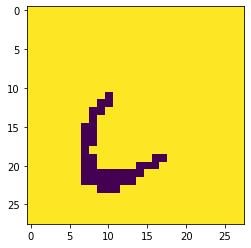

In [312]:
plt.imshow(img_filtered[2] <= 0.5)

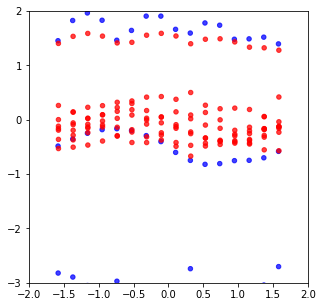

In [87]:
dgm_pht = pht(img_filtered, pos=np.array(alphas), eps=0.05)
dgm_pht_pca = PCA(n_components=3, whiten=True).fit_transform(dgm_pht)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 2)
ax.scatter(dgm_pht_pca[:,0], dgm_pht_pca[:,2], s=20, c=dgm_pht[:,2], alpha=0.75, cmap="bwr")
plt.show()

In [88]:
dgm_pht.shape

torch.Size([175, 4])

### C-MNIST

In [40]:
transform_cmnist = Compose([
    Lambda(lambda x: x / 255),
    Dilate(3),
    HardThreshold(0.1),
    Resize((32, 32)),
    CenterCrop(28),
    ToDtype(torch.float32),
])

In [41]:
df = pd.read_csv("../data/_raw/c-mnist/c-mnist/chinese_mnist.csv")

X_cmnist = torch.zeros((len(df), 28, 28), dtype=torch.float32)
y_cmnist = torch.zeros(len(df), dtype=torch.int64)

for i, (suite_id, sample_id, code, *__) in df.iterrows():
    img = read_image("../data/_raw/c-mnist/c-mnist/data/data/input_{}_{}_{}.jpg".format(suite_id, sample_id, code))
    X_cmnist[i] = transform_cmnist(img).squeeze(0)
    y_cmnist[i] = code

In [42]:
X_cmnist.shape, y_cmnist.shape

(torch.Size([15000, 28, 28]), torch.Size([15000]))

In [43]:
X_cmnist.dtype, y_cmnist.dtype

(torch.float32, torch.int64)

In [44]:
rng = np.random.default_rng(0)
idx = rng.choice(range(len(X_cmnist)), 10, replace=False)

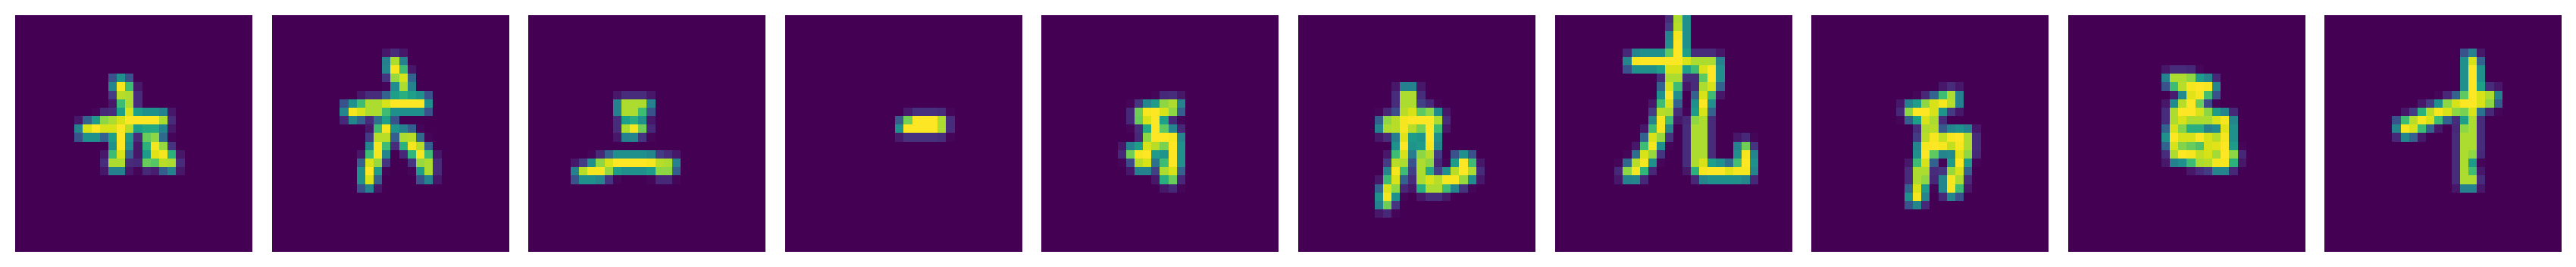

In [20]:
fig, ax = plt.subplots(ncols=10, figsize=(17, 1.7), dpi=200)
for i, ii in enumerate(idx):
    ax[i].axis("off")
    ax[i].imshow(X_cmnist[ii].numpy())
plt.tight_layout(pad=0.5)
plt.show()

In [45]:
img_filtered = f(X_cmnist[0])
img_filtered.shape

torch.Size([16, 28, 28])

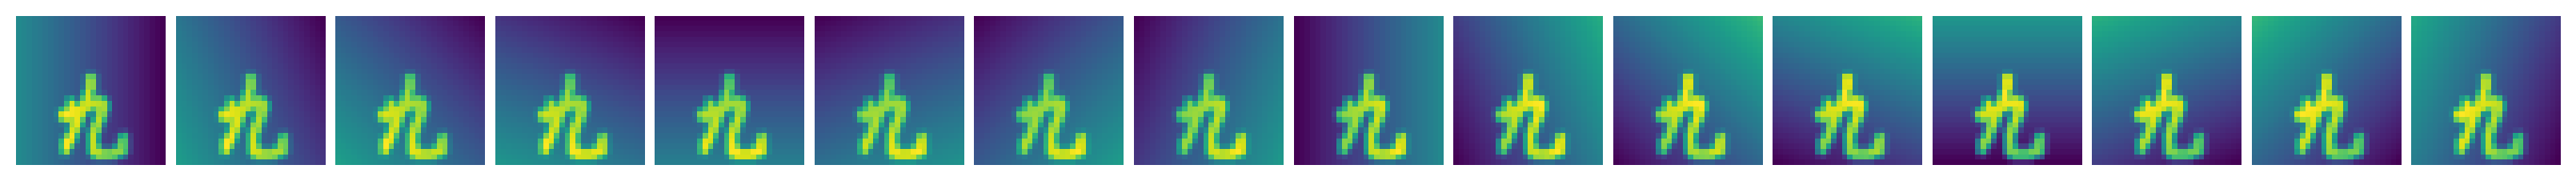

In [46]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

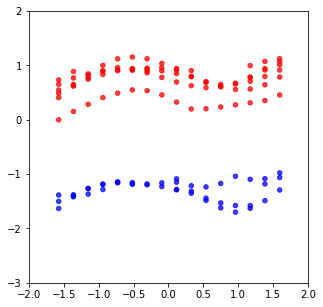

In [47]:
dgm_pht = pht(img_filtered, pos=alphas, eps=0.05)
dgm_pht_pca = PCA(n_components=2, whiten=True).fit_transform(dgm_pht)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-2, 2)
ax.set_ylim(-3, 2)
ax.scatter(dgm_pht_pca[:,0], dgm_pht_pca[:,1], s=20, c=dgm_pht[:,2], alpha=0.75, cmap="bwr")
plt.show()

### J-MNIST

In [23]:
X_jmnist_train = torch.tensor(np.load("../data/_raw/j-mnist/j-mnist/kmnist-train-imgs.npz")["arr_0"])
X_jmnist_test = torch.tensor(np.load("../data/_raw/j-mnist/j-mnist/kmnist-test-imgs.npz")["arr_0"])
y_jmnist_train = torch.tensor(np.load("../data/_raw/j-mnist/j-mnist/kmnist-train-labels.npz")["arr_0"])
y_jmnist_test = torch.tensor(np.load("../data/_raw/j-mnist/j-mnist/kmnist-test-labels.npz")["arr_0"])

In [24]:
X_jmnist_train.shape, X_jmnist_test.shape, y_jmnist_train.shape, y_jmnist_test.shape

(torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000]))

In [25]:
X_jmnist_train.dtype, X_jmnist_test.dtype, y_jmnist_train.dtype, y_jmnist_test.dtype

(torch.uint8, torch.uint8, torch.uint8, torch.uint8)

In [26]:
rng = np.random.default_rng(0)
idx = rng.choice(range(len(X_jmnist_train)), 10, replace=False)

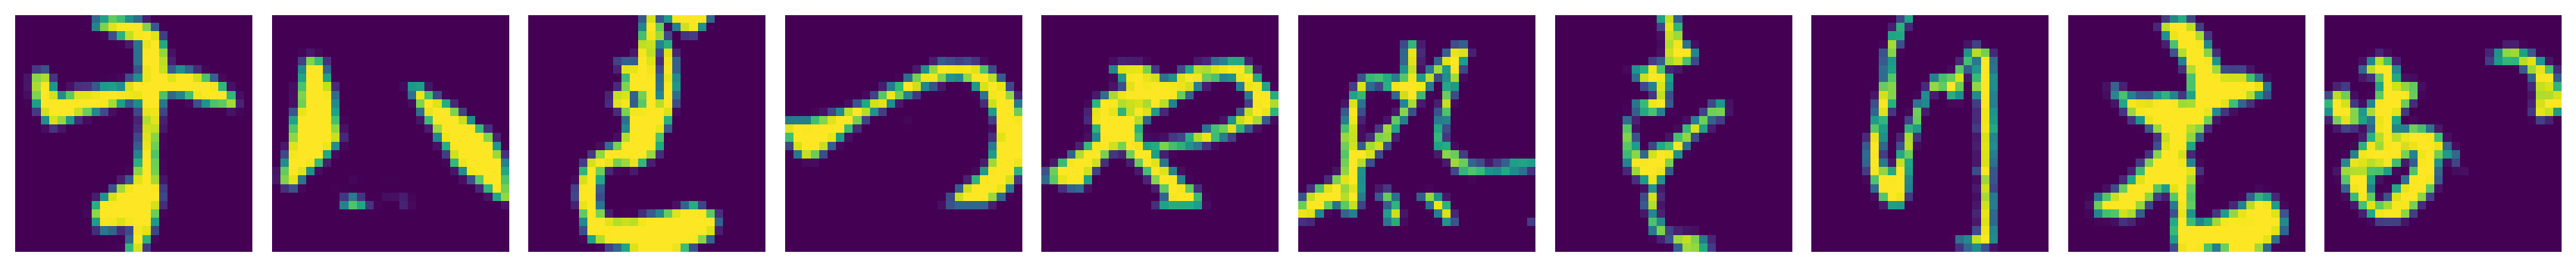

In [27]:
fig, ax = plt.subplots(ncols=10, figsize=(17, 1.7), dpi=200)
for i, ii in enumerate(idx):
    ax[i].axis("off")
    ax[i].imshow(X_jmnist_train[ii].numpy())
plt.tight_layout(pad=0.5)
plt.show()

In [28]:
transform_jmnist = Compose([
    Lambda(lambda x: x / 255),
    ToDtype(torch.float32),
])

In [29]:
X_jmnist_train[6].shape

torch.Size([28, 28])

In [30]:
img_filtered = f(transform_jmnist(X_jmnist_train[11]))
img_filtered.shape

torch.Size([16, 28, 28])

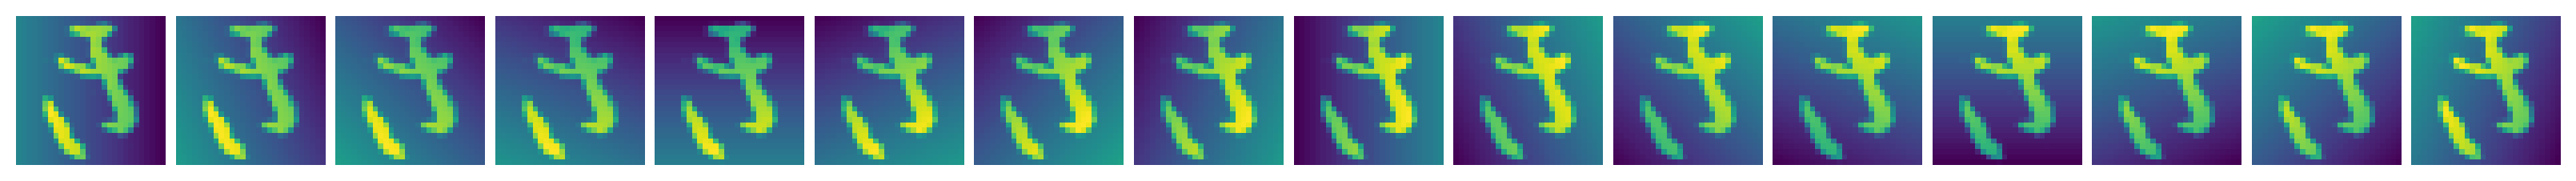

In [31]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

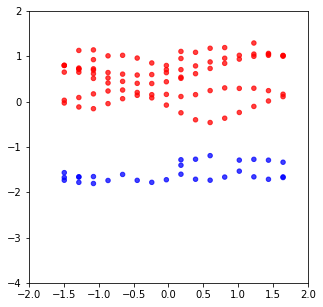

In [32]:
dgm_pht = pht(img_filtered, pos=alphas, eps=0.05)
dgm_pht_pca = PCA(n_components=2, whiten=True).fit_transform(dgm_pht)

fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim(-2, 2)
ax.set_ylim(-4, 2)
ax.scatter(dgm_pht_pca[:,0], dgm_pht_pca[:,1], s=20, c=dgm_pht[:,2], alpha=0.75, cmap="bwr")
plt.show()

In [33]:
dgm_pht_pca.shape

(119, 2)

### CIFAR-10

In [313]:
cifar_train = CIFAR10(root="../data/_tmp/", train=True, download=True)
cifar_test = CIFAR10(root="../data/_tmp/", train=False, download=True)

X_cifar_train, y_cifar_train = torch.tensor(cifar_train.data), torch.tensor(cifar_train.targets)
X_cifar_test, y_cifar_test = torch.tensor(cifar_test.data), torch.tensor(cifar_test.targets)

In [314]:
X_cifar_train.shape, X_cifar_test.shape, y_cifar_train.shape, y_cifar_test.shape

(torch.Size([50000, 32, 32, 3]),
 torch.Size([10000, 32, 32, 3]),
 torch.Size([50000]),
 torch.Size([10000]))

In [315]:
X_cifar_train.dtype, X_cifar_test.dtype, y_cifar_train.dtype, y_cifar_test.dtype

(torch.uint8, torch.uint8, torch.int64, torch.int64)

In [316]:
rng = np.random.default_rng(0)
idx = rng.choice(range(len(X_cifar_train)), 10, replace=False)

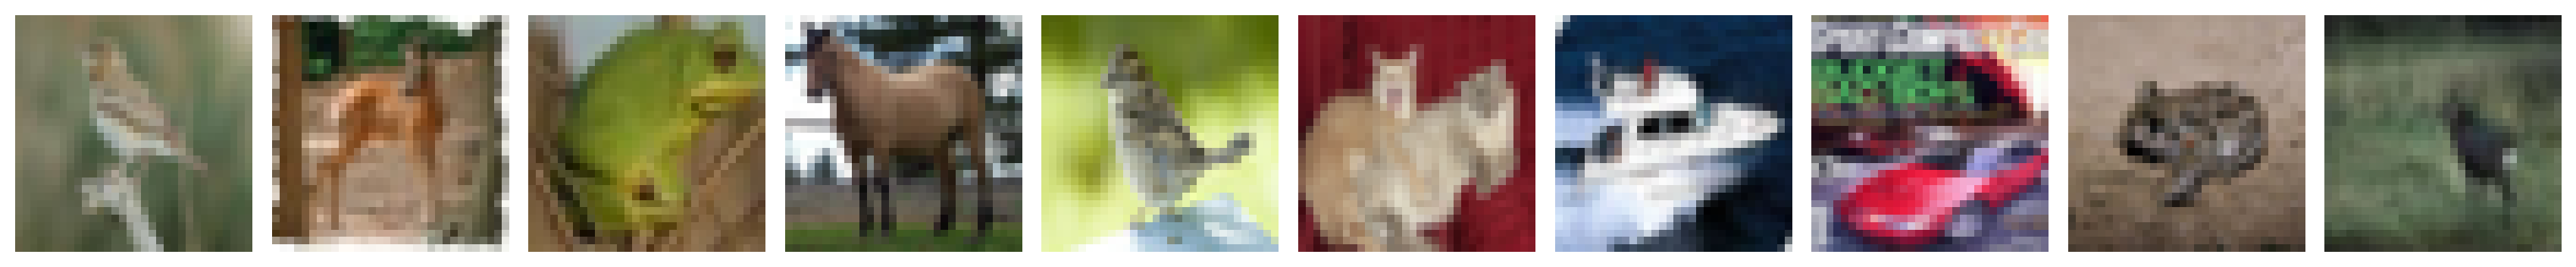

In [317]:
fig, ax = plt.subplots(ncols=10, figsize=(17, 1.7), dpi=200)
for i, ii in enumerate(idx):
    ax[i].axis("off")
    ax[i].imshow(X_cifar_train[ii].numpy())
plt.tight_layout(pad=0.5)
plt.show()

In [318]:
X_cifar_train.shape

torch.Size([50000, 32, 32, 3])

In [319]:
img_filtered = f(transform_jmnist(X_cifar_train[4][:,:,2]))
img_filtered.shape

ValueError: Only sizes of 28x28 and 64x64 pixels are supported.

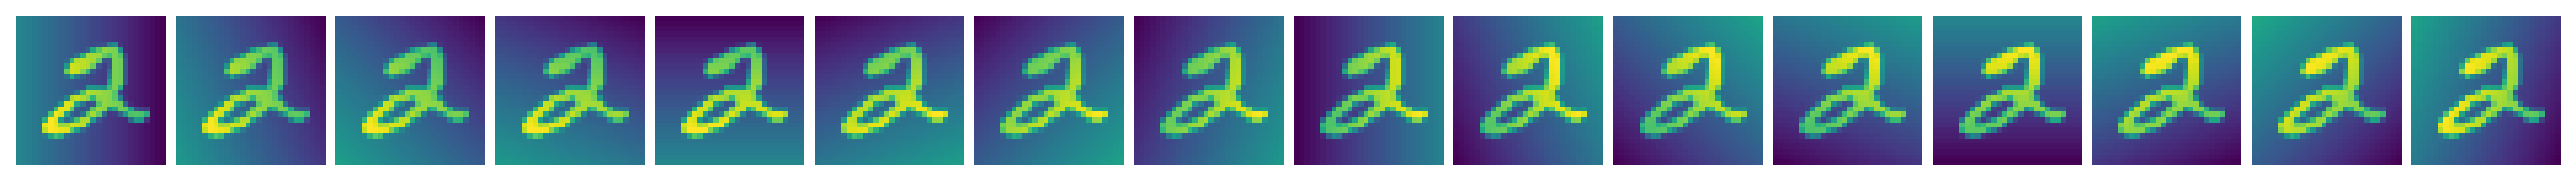

In [97]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

In [98]:
img_filtered.shape

torch.Size([16, 28, 28])

In [ ]:
dgm_pht = pht(img_filtered, pos=alphas, eps=0.05)
dgm_pht_pca = PCA(n_components=2, whiten=True).fit_transform(dgm_pht)

fig, ax = plt.subplots(figsize=(5,5))
# ax.set_xlim(-3, 3)
# ax.set_ylim(-3, 3)
ax.scatter(dgm_pht_pca[:,0], dgm_pht_pca[:,1], s=20, c=dgm_pht[:,2], alpha=0.75, cmap="bwr")
plt.show()

### BLOBS

In [99]:
seed = 0
n = 600+100

rng = np.random.default_rng(seed)
random_seeds = rng.choice(range(10000000), n, replace=False)

In [100]:
def gen_image(blobiness, porosity, W=64, random_seed=0):
    return ps.generators.blobs([W, W], blobiness=blobiness, porosity=porosity, seed=random_seed)

In [101]:
X_blobs = torch.zeros((n, 64, 64))

for i in tqdm(range(n)):
    X_blobs[i] = torch.tensor(gen_image(0.5, 0.5, random_seed=random_seeds[i]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:00<00:00, 4968.98it/s]


In [102]:
rng = np.random.default_rng(0)
idx = rng.choice(range(len(X_blobs)), 10, replace=False)

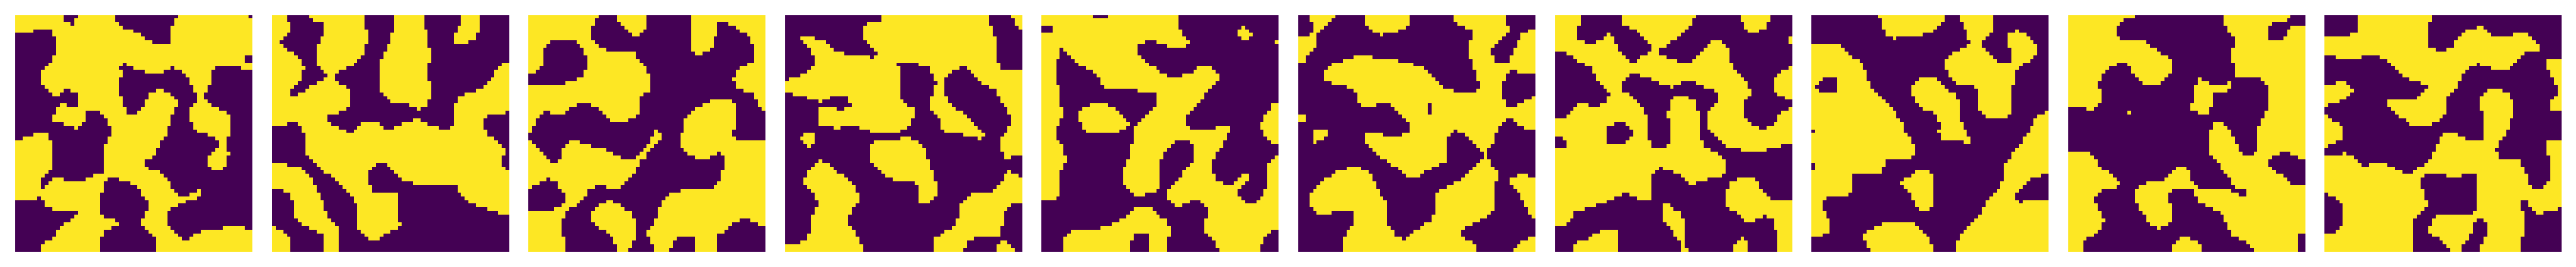

In [103]:
fig, ax = plt.subplots(ncols=10, figsize=(17, 1.7), dpi=200)
for i, ii in enumerate(idx):
    ax[i].axis("off")
    ax[i].imshow(X_blobs[ii])
plt.tight_layout(pad=0.5)
plt.show()

In [104]:
transform_blobs = Compose([
    ToDtype(torch.float32, scale=True),
])

In [105]:
img_filtered = f(transform_blobs(X_blobs[1]))
img_filtered.shape

torch.Size([16, 64, 64])

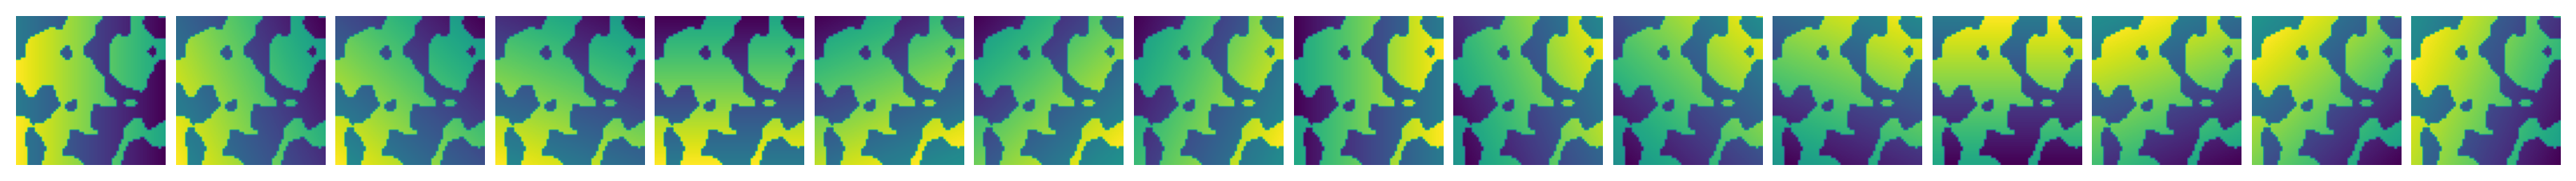

In [106]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

In [107]:
from scipy.ndimage import rotate

In [108]:
n_dir = 16

thetas = np.linspace(0, 360, n_dir+1)[:-1]
alphas = list(np.linspace(0, 2*np.pi, n_dir+1)[:-1])
thetas

array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. , 202.5, 225. , 247.5, 270. , 292.5, 315. , 337.5])

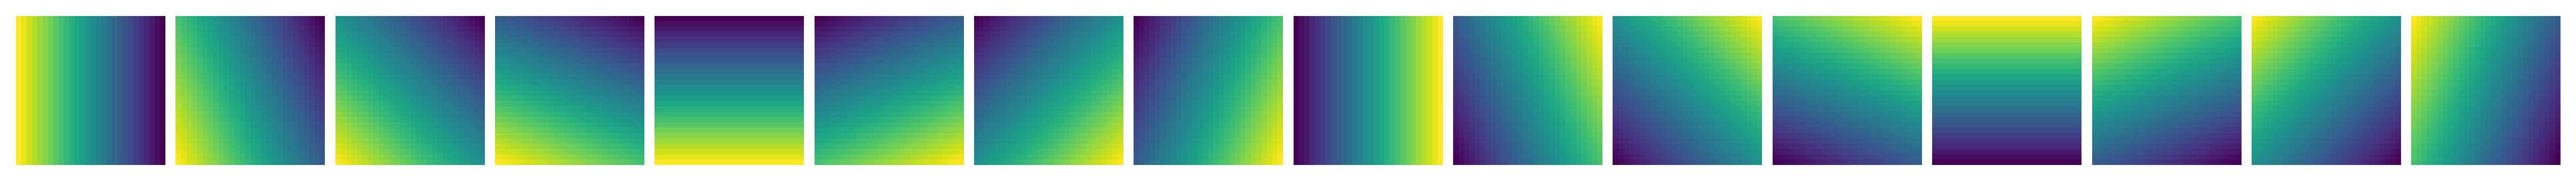

In [109]:
img = np.array(X_mnist_train[31]) / 255
img40 = np.zeros((40, 40))
img40[6:28+6, 6:28+6] = img
gradient = np.repeat(np.linspace(1, 0, 40), 40).reshape(40, 40).T

img_filtered = np.zeros((len(thetas), 28, 28))

fig, ax = plt.subplots(ncols=len(thetas), figsize=(16, 1), dpi=300)
for i, theta in enumerate(thetas):
    ax[i].axis("off")
    img_filtered_i = (rotate(gradient, theta, reshape=False))[6:34,:][:,6:34]
    img_filtered[i] = img_filtered_i
    ax[i].imshow(img_filtered_i)
plt.tight_layout(pad=0.25)
plt.show()

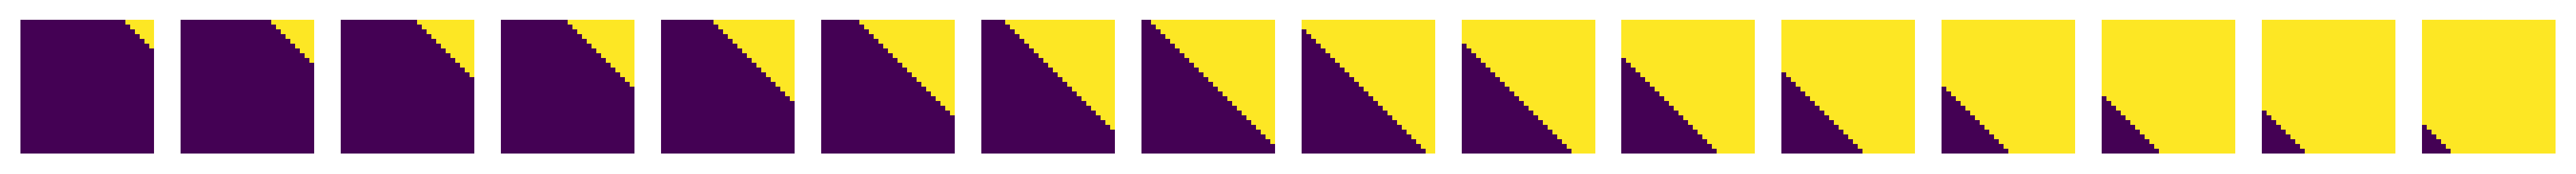

In [110]:
fig, ax = plt.subplots(ncols=16, figsize=(16, 1), dpi=300)
for i, t in enumerate(np.linspace(0, 1, 16+2+2)[2:-2]):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[2] < t)
plt.show()

In [111]:
sublevel_persistence(torch.tensor(img_filtered[0]).unsqueeze(0), eps=0.02)

[tensor([[0.15, 0.85, 0.00]], dtype=torch.float64)]

In [112]:
sublevel_persistence(torch.tensor(img_filtered[-1]).unsqueeze(0), eps=0.02)

[tensor([[0.05, 0.95, 0.00]], dtype=torch.float64)]

In [113]:
dgm_pht = pht(torch.tensor(img_filtered), pos=alphas, eps=0.03)
dgm_pht_pca = PCA(n_components=2, whiten=True).fit_transform(dgm_pht)

fig, ax = plt.subplots(figsize=(5,5))
# ax.set_xlim(-3, 3)
# ax.set_ylim(-3, 3)
ax.scatter(dgm_pht_pca[:,0], dgm_pht_pca[:,1], s=15, c=dgm_pht[:,2], alpha=0.75, cmap="bwr")
plt.show()

TypeError: can't multiply sequence by non-int of type 'float'

### OBAYASHI

In [123]:
seed = 0
n = 600+100

rng = np.random.default_rng(seed)
random_seeds = rng.choice(range(10000000), n, replace=False)

In [124]:
def gen_image(N, S, sigma1=4.0, sigma2=2.0, W=300, t=0.01, random_seed=0):
    
    # random number generator
    rng = np.random.default_rng(random_seed)
    
    # sample random walks on torus
    x = []
    for n in range(N):
        x.append(rng.random(2) * W)
        for s in range(S):
            x.append((x[-1] + (rng.normal(size=2) * sigma1)) % W)
    x = np.array(x)
    
    # smooth + binarize
    H, _, _ = np.histogram2d(x[:, 0], x[:, 1], bins=W, range=[[0, W], [0, W]])
    H = sp.ndimage.gaussian_filter(H, sigma2)
    
    return (H < t) * 1.

In [125]:
X_obayashi = torch.zeros((n, 64, 64))

for i in tqdm(range(n)):
    X_obayashi[i] = torch.tensor(gen_image(25, 20, W=64, sigma1=1.5, sigma2=1.0, random_seed=random_seeds[i]))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 700/700 [00:01<00:00, 692.57it/s]


In [126]:
rng = np.random.default_rng(0)
idx = rng.choice(range(len(X_obayashi)), 10, replace=False)

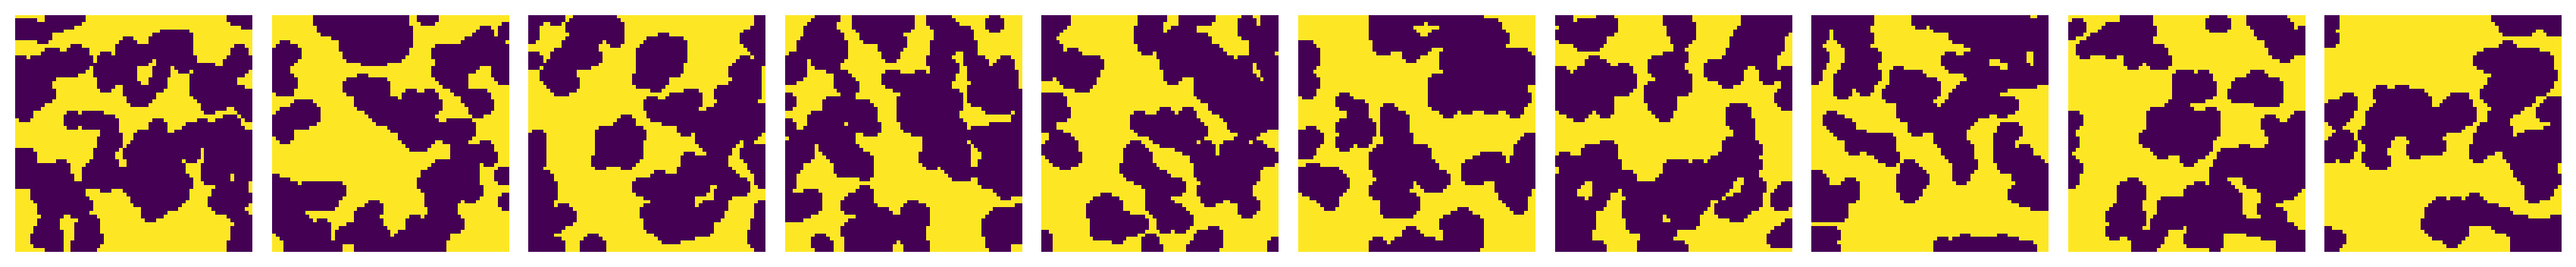

In [127]:
fig, ax = plt.subplots(ncols=10, figsize=(17, 1.7), dpi=200)
for i, ii in enumerate(idx):
    ax[i].axis("off")
    ax[i].imshow(X_obayashi[ii])
plt.tight_layout(pad=0.5)
plt.show()

In [399]:
transform_obayashi = Compose([
    ToDtype(torch.float32, scale=True),
])

In [412]:
alphas = np.linspace(0, 360, 16+1)[:-1]
f = Direction(alphas, agg="add") # add > max

img_filtered = f(transform_obayashi(X_obayashi[0]))
img_filtered.shape

torch.Size([16, 64, 64])

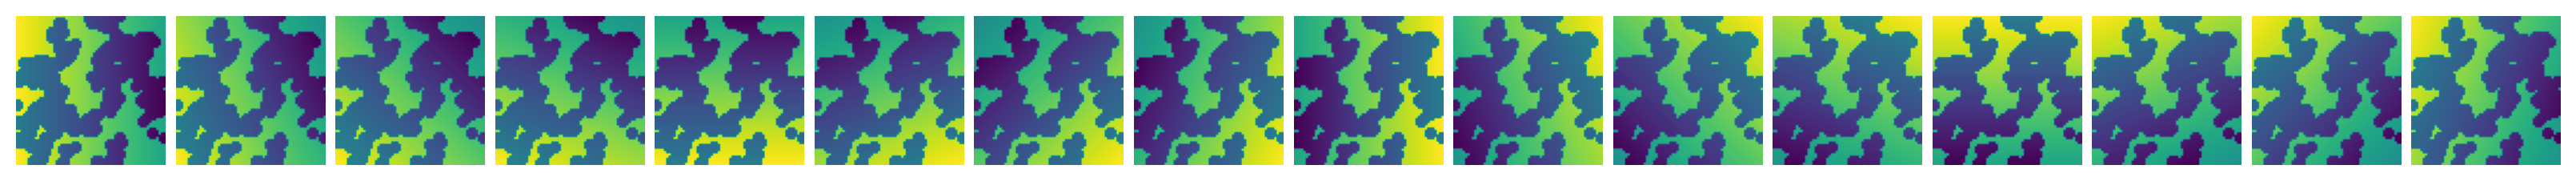

In [413]:
fig, ax = plt.subplots(ncols=len(img_filtered), figsize=(16, 1), dpi=200)
for i in range(len(img_filtered)):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[i])
plt.tight_layout(pad=0.25)
plt.show()

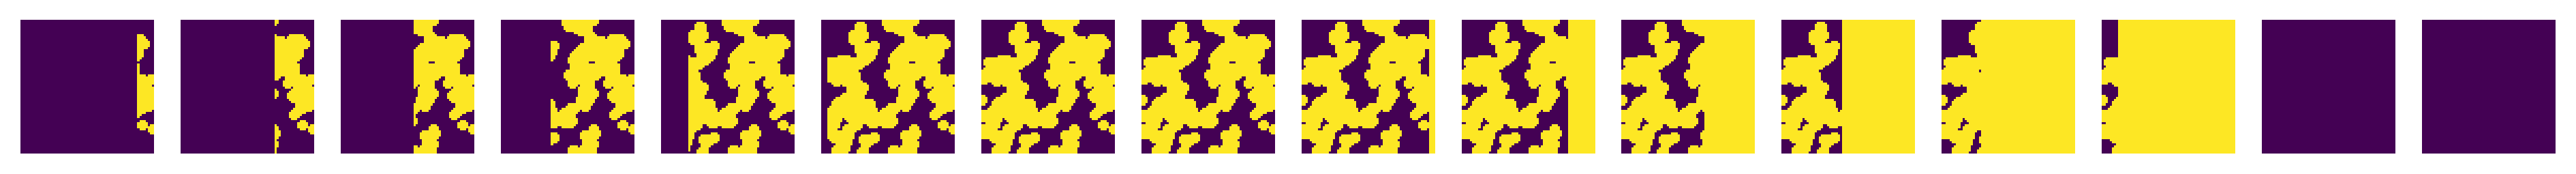

In [414]:
fig, ax = plt.subplots(ncols=16, figsize=(16, 1), dpi=300)
for i, t in enumerate(np.linspace(0, 2, 16+2)[2:]):
    ax[i].axis("off")
    ax[i].imshow(img_filtered[0] <= t)
plt.show()

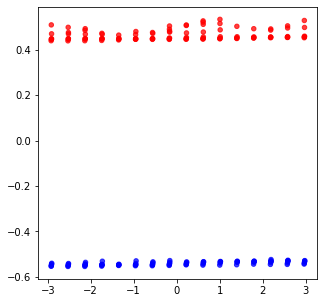

In [411]:
dgm_pht = pht(img_filtered, pos=alphas*(np.pi/180), eps=0.05)
dgm_pht_pca = PCA(n_components=3, whiten=False).fit_transform(dgm_pht)

fig, ax = plt.subplots(figsize=(5,5))
# ax.set_xlim(-2, 2)
# ax.set_ylim(-3, 2)
ax.scatter(dgm_pht_pca[:,0], dgm_pht_pca[:,1], s=20, c=dgm_pht[:,2], alpha=0.75, cmap="bwr")
plt.show()

In [236]:
dgm_pht.shape

torch.Size([220, 4])